In [1]:
pip install shap grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=c3a9e6f0e66703e3b2ea43cb561e92dde0fb7455d14dc90d0b98607913e6a499
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Add, LayerNormalization, Multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from keras_tuner.tuners import RandomSearch  # Updated import
from tensorflow.keras.regularizers import l2
import joblib
import os

# Create output directory
output_dir = '/kaggle/working/models'
os.makedirs(output_dir, exist_ok=True)

# Load tabular data
tabular_data_path = '/kaggle/input/asifazmain/tabulardata1.csv'
tabular_data = pd.read_csv(tabular_data_path)

# Preprocessing Tabular Data
tabular_features = tabular_data.drop(columns=["faceImage"])
tabular_labels = tabular_data["Age(years)"]

# Normalize age labels
label_scaler = StandardScaler()
y_tabular_scaled = label_scaler.fit_transform(tabular_labels.values.reshape(-1, 1)).flatten()

# Save label scaler
joblib.dump(label_scaler, os.path.join(output_dir, 'label_scaler.pkl'))

# Extract features and labels
X_tabular = tabular_features.drop(columns=["Age(years)"])
y_tabular = y_tabular_scaled

# Handle categorical and numerical features
categorical_features = ["Blood Pressure (s/d)"]
numerical_features = [col for col in X_tabular.columns if col not in categorical_features]

# Preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

# Preprocess tabular data
X_tabular_preprocessed = preprocessor.fit_transform(X_tabular)

# Save preprocessor
joblib.dump(preprocessor, os.path.join(output_dir, 'preprocessor.pkl'))

# Convert sparse to dense if needed
if isinstance(X_tabular_preprocessed, csr_matrix):
    X_tabular_preprocessed = X_tabular_preprocessed.toarray()

# Image IDs
image_ids = tabular_data["faceImage"]

# Split data
X_tabular_train, X_tabular_test, y_train, y_test, image_ids_train, image_ids_test = train_test_split(
    X_tabular_preprocessed, y_tabular, image_ids, test_size=0.2, random_state=42
)

# Image preprocessing
image_data_path = '/kaggle/input/asifazmain/imagedata/imagedata/'
image_size = (128, 128)
batch_size = 4

train_image_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_image_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_image_generator = train_image_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': image_ids_train.apply(lambda x: f'{x}.jpg')}),
    directory=image_data_path,
    x_col='filename',
    y_col=None,
    target_size=image_size,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

test_image_generator = test_image_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': image_ids_test.apply(lambda x: f'{x}.jpg')}),
    directory=image_data_path,
    x_col='filename',
    y_col=None,
    target_size=image_size,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

# Align images and tabular data
def create_tf_dataset(image_gen, tabular_data, labels, batch_size):
    images = []
    valid_indices = []
    for i in range(len(image_gen)):
        batch = image_gen[i]
        batch_size_actual = batch.shape[0]
        start_idx = i * image_gen.batch_size
        end_idx = start_idx + batch_size_actual
        if end_idx > len(tabular_data):
            batch = batch[:len(tabular_data) - start_idx]
            images.append(batch)
            valid_indices.extend(range(start_idx, start_idx + batch.shape[0]))
            break
        images.append(batch)
        valid_indices.extend(range(start_idx, end_idx))
    
    images = np.concatenate(images, axis=0)
    tabular_data = tabular_data[valid_indices]
    labels = labels[valid_indices]
    
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'image_input': images,
            'tabular_input': tabular_data.astype(np.float32)
        },
        labels.astype(np.float32)
    ))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_dataset = create_tf_dataset(train_image_generator, X_tabular_train, y_train, batch_size)
test_dataset = create_tf_dataset(test_image_generator, X_tabular_test, y_test, batch_size)

# CNN model
def build_model(hp):
    image_input = Input(shape=(*image_size, 3), name="image_input")
    x = Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=96, step=32),
        kernel_size=3,
        activation="relu",
        padding="same"
    )(image_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    shortcut = x
    x = Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=128, step=32),
        kernel_size=3,
        activation="relu",
        padding="same"
    )(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=128, step=32),
        kernel_size=1,
        padding="same"
    )(shortcut)
    x = Add()([x, shortcut])
    
    x = Conv2D(
        filters=hp.Int('conv3_filters', min_value=96, max_value=192, step=32),
        kernel_size=3,
        activation="relu",
        padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    shortcut = x
    x = Conv2D(
        filters=hp.Int('conv4_filters', min_value=128, max_value=256, step=64),
        kernel_size=3,
        activation="relu",
        padding="same"
    )(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(
        filters=hp.Int('conv4_filters', min_value=128, max_value=256, step=64),
        kernel_size=1,
        padding="same"
    )(shortcut)
    x = Add()([x, shortcut])
    
    x = Conv2D(
        filters=hp.Int('conv5_filters', min_value=192, max_value=384, step=64),
        kernel_size=3,
        dilation_rate=2,
        activation="relu",
        padding="same"
    )(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(
        filters=hp.Int('conv6_filters', min_value=256, max_value=512, step=64),
        kernel_size=3,
        activation="relu",
        padding="same"
    )(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dense(
        units=hp.Int('image_dense_units', min_value=128, max_value=512, step=128),
        activation="relu",
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-4, max_value=5e-2, sampling='log'))
    )(x)
    x = Dropout(hp.Float('dropout_image', min_value=0.3, max_value=0.6))(x)
    x = BatchNormalization()(x)
    image_output = Dense(64, activation="relu", name="image_output")(x)

    tabular_input = Input(shape=(X_tabular_preprocessed.shape[1],), name="tabular_input")
    y = Dense(
        units=hp.Int('tabular_units_1', min_value=128, max_value=512, step=128),
        activation="relu",
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-4, max_value=5e-2, sampling='log'))
    )(tabular_input)
    y = LayerNormalization()(y)
    y = Dropout(hp.Float('dropout_tabular_1', min_value=0.3, max_value=0.6))(y)
    y = Dense(
        units=hp.Int('tabular_units_2', min_value=64, max_value=256, step=64),
        activation="relu",
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-4, max_value=5e-2, sampling='log'))
    )(y)
    y = LayerNormalization()(y)
    tabular_output = Dense(64, activation="relu", name="tabular_output")(y)

    concatenated = Concatenate()([image_output, tabular_output])
    fused = Multiply()([image_output, tabular_output])
    fused = Dense(64, activation="relu")(fused)
    combined = Concatenate()([concatenated, fused])
    
    z = Dense(
        units=hp.Int('concat_units', min_value=128, max_value=512, step=128),
        activation="relu",
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-4, max_value=5e-2, sampling='log'))
    )(combined)
    z = Dropout(hp.Float('dropout_concat', min_value=0.3, max_value=0.6))(z)
    z = BatchNormalization()(z)
    final_output = Dense(1, activation="linear", name="final_output")(z)

    lr_schedule = CosineDecay(
        initial_learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log'),
        decay_steps=10000
    )
    model = Model(inputs=[image_input, tabular_input], outputs=final_output)
    model.compile(
        optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-4, clipnorm=1.0),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='cnn_6layers_low_mae'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, mode='min')
checkpoint = ModelCheckpoint(
    os.path.join(output_dir, 'best_model.keras'),  # Changed to .keras
    monitor='val_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Perform tuning
tuner.search(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the final model explicitly
best_model.save(os.path.join(output_dir, 'final_model.keras'))  # Changed to .keras

# Evaluate with additional metrics
loss, mae_scaled = best_model.evaluate(test_dataset)
print(f"Test Loss (Scaled): {loss}, Test MAE (Scaled): {mae_scaled}")

# Convert MAE back to original scale
mae_original = label_scaler.inverse_transform([[mae_scaled]])[0][0] - label_scaler.inverse_transform([[0]])[0][0]
print(f"Test MAE (Original Scale): {mae_original}")

# Get predictions for the test dataset
y_pred_scaled = []
y_true_scaled = []
for batch in test_dataset:
    inputs, labels = batch
    preds = best_model.predict(inputs, verbose=0)
    y_pred_scaled.extend(preds.flatten())
    y_true_scaled.extend(labels.numpy().flatten())

y_pred_scaled = np.array(y_pred_scaled)
y_true_scaled = np.array(y_true_scaled)

# Inverse-transform predictions and true labels to original scale
y_pred_original = label_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true_original = label_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

# Calculate overall accuracy (±0.5 years in original scale)
accuracy_0_5 = np.mean(np.abs(y_pred_original - y_true_original) <= 0.5) * 100
print(f"Overall Accuracy (±0.5 years): {accuracy_0_5:.2f}%")

# Calculate R-squared in original scale
r2 = r2_score(y_true_original, y_pred_original)
print(f"R² Score (Original Scale): {r2:.4f}")

# Optional: Accuracy with rounded ages
accuracy_rounded = np.mean(np.round(y_pred_original) == np.round(y_true_original)) * 100
print(f"Accuracy (Rounded to Nearest Integer): {accuracy_rounded:.2f}%")



Trial 15 Complete [00h 01m 37s]
val_mae: 0.5935455858707428

Best val_mae So Far: 0.46179117262363434
Total elapsed time: 00h 35m 09s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 1 variables whereas the saved optimizer has 105 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 1.7586 - mae: 0.3869
Test Loss (Scaled): 1.8496322631835938, Test MAE (Scaled): 0.4345267117023468
Test MAE (Original Scale): 7.485883473334514
Overall Accuracy (±0.5 years): 9.52%


NameError: name 'r2_score' is not defined

In [2]:
# Final training
history = best_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)

# Add the corrected evaluation code here
import numpy as np
from sklearn.metrics import r2_score  # Added import for r2_score
import matplotlib.pyplot as plt

# Get predictions for the test dataset
y_pred_scaled = []
y_true_scaled = []
for batch in test_dataset:
    inputs, labels = batch
    preds = best_model.predict(inputs, verbose=0)
    y_pred_scaled.extend(preds.flatten())
    y_true_scaled.extend(labels.numpy().flatten())

y_pred_scaled = np.array(y_pred_scaled)
y_true_scaled = np.array(y_true_scaled)

# Inverse-transform predictions and true labels to original scale
y_pred_original = label_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true_original = label_scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).flatten()

# Calculate overall accuracy (±0.5 years in original scale)
accuracy_0_5 = np.mean(np.abs(y_pred_original - y_true_original) <= 0.5) * 100
print(f"Overall Accuracy (±0.5 years): {accuracy_0_5:.2f}%")

# Calculate R-squared in original scale
r2 = r2_score(y_true_original, y_pred_original)
print(f"R² Score (Original Scale): {r2:.4f}")

# Optional: Accuracy with rounded ages (exact integer matches)
accuracy_rounded = np.mean(np.round(y_pred_original) == np.round(y_true_original)) * 100
print(f"Accuracy (Rounded to Nearest Integer): {accuracy_rounded:.2f}%")

# Plot predicted vs. actual ages
plt.figure(figsize=(8, 8))
plt.scatter(y_true_original, y_pred_original, alpha=0.5, label='Predictions')
plt.plot([y_true_original.min(), y_true_original.max()], [y_true_original.min(), y_true_original.max()], 'r--', label='Ideal')
plt.xlabel('Actual Age (Years)')
plt.ylabel('Predicted Age (Years)')
plt.title('Predicted vs. Actual Ages')
plt.legend()
plt.savefig('/kaggle/working/models/pred_vs_actual.png')
plt.close()
print("Predicted vs. actual ages plot saved at /kaggle/working/models/pred_vs_actual.png")

# Optional: Save model in TensorFlow.js format
try:
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(best_model, os.path.join(output_dir, 'tfjs_model'))
    print("TensorFlow.js model saved successfully.")
except ImportError:
    print("TensorFlow.js not installed. Skipping TF.js model saving.")

Epoch 1/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6621 - mae: 0.5321
Epoch 1: val_mae improved from inf to 0.52609, saving model to /kaggle/working/models/best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - loss: 1.6548 - mae: 0.5398 - val_loss: 1.5312 - val_mae: 0.5261
Epoch 2/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5103 - mae: 0.5608
Epoch 2: val_mae did not improve from 0.52609
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5241 - mae: 0.5706 - val_loss: 1.6701 - val_mae: 0.5647
Epoch 3/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5846 - mae: 0.5707
Epoch 3: val_mae improved from 0.52609 to 0.50168, saving model to /kaggle/working/models/best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 1.5950 - mae: 0.5773 - val_loss: 1.7130 - val_mae: 0.5017
Epoch 4/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5138 - mae: 0.4790
Epoch 4: val_mae did not improve from 0.50168
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.543

In [6]:
# Prediction function 
def predict_age(image_path, height_cm, weight_kg, bmi, blood_pressure, blood_oxygen, blood_sugar, model, preprocessor, label_scaler, image_size=(128, 128)):
    """
    Predict age using an image and biomarkers.
    
    Parameters:
    - image_path (str): Path to the user's face image
    - height_cm (float): Height in centimeters
    - weight_kg (float): Weight in kilograms
    - bmi (float): Body Mass Index
    - blood_pressure (str): Blood pressure in 'systolic/diastolic' format (e.g., '120/80')
    - blood_oxygen (float): Blood oxygen level in percentage
    - blood_sugar (float): Blood sugar level in mg/dL
    - model: Trained Keras model (best_model)
    - preprocessor: Fitted ColumnTransformer from training
    - label_scaler: Fitted StandardScaler for age labels
    - image_size (tuple): Target image size (default: (128, 128))
    
    Returns:
    - predicted_age (float): Predicted age in years
    """
    
    # 1. Preprocess the image
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Rescale as in test_image_datagen
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: (1, 128, 128, 3)

    # 2. Preprocess the tabular data (biomarkers)
    biomarkers = {
        'Height (cm)': height_cm,
        'Weight (kg)': weight_kg,
        'BMI': bmi,
        'Blood Pressure (s/d)': blood_pressure,
        'Blood Oxygen': blood_oxygen,
        'Blood Sugar(mg/dl)': blood_sugar
    }
    
    # Create DataFrame with all required columns (match training data structure)
    tabular_df = pd.DataFrame([biomarkers])
    
    # Ensure all columns from training are present, fill missing with median or mode from training data
    for col in X_tabular.columns:
        if col not in tabular_df.columns:
            if col in numerical_features:
                tabular_df[col] = X_tabular[col].median()  # Use median for numerical
            elif col in categorical_features:
                tabular_df[col] = X_tabular[col].mode()[0]  # Use mode for categorical
    
    # Reorder columns to match training data
    tabular_df = tabular_df[X_tabular.columns]
    
    # Apply preprocessing
    tabular_processed = preprocessor.transform(tabular_df)
    if isinstance(tabular_processed, csr_matrix):
        tabular_processed = tabular_processed.toarray()
    
    # Ensure tabular_processed is 2D (batch_size, features)
    if len(tabular_processed.shape) > 2:
        tabular_processed = tabular_processed.squeeze()  # Remove extra dimensions if any
    if len(tabular_processed.shape) == 1:
        tabular_processed = np.expand_dims(tabular_processed, axis=0)  # Add batch dimension if missing
    # Now tabular_processed should be (1, 77) or similar, matching the model's expected shape

    # 3. Make prediction
    inputs = {
        'image_input': img_array,
        'tabular_input': tabular_processed.astype(np.float32)
    }
    prediction_scaled = model.predict(inputs)[0][0]  # Get single value
    
    # 4. Convert to original scale
    predicted_age = label_scaler.inverse_transform([[prediction_scaled]])[0][0]
    
    return predicted_age

In [7]:
# Example usage of predict_age
example_image_path = '/kaggle/input/asifazmain/imagedata/imagedata/29.jpg'  # Example image path
example_height_cm = 168.91
example_weight_kg = 60.0
example_bmi = 21.03
example_blood_pressure = '100/68'
example_blood_oxygen = 97.0
example_blood_sugar = 104.4

predicted_age = predict_age(
    image_path=example_image_path,
    height_cm=example_height_cm,
    weight_kg=example_weight_kg,
    bmi=example_bmi,
    blood_pressure=example_blood_pressure,
    blood_oxygen=example_blood_oxygen,
    blood_sugar=example_blood_sugar,
    model=best_model,
    preprocessor=preprocessor,
    label_scaler=label_scaler
)

print(f"Predicted Age: {predicted_age:.2f} years")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
Predicted Age: 29.98 years


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
No face detected in the image.
No face detected in the image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


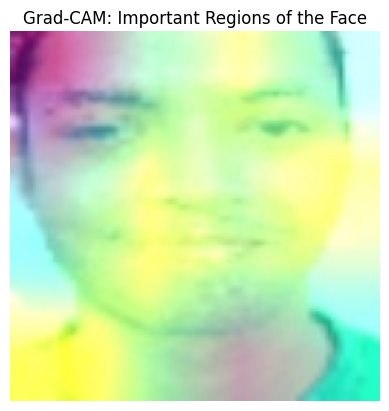

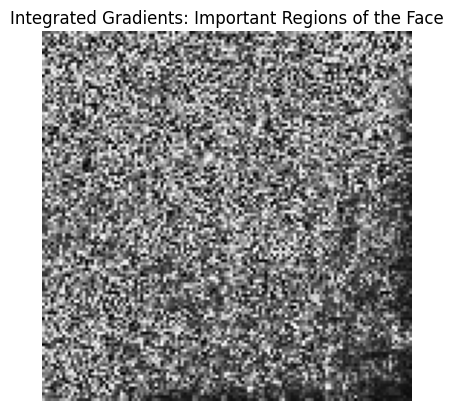

No face detected in the image.
No face detected in the image.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


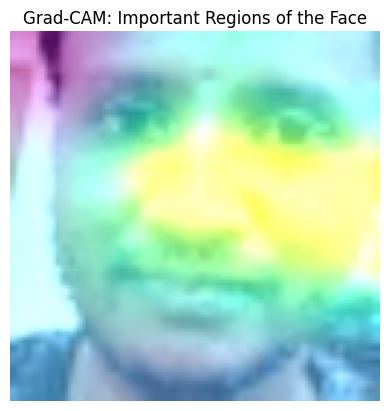

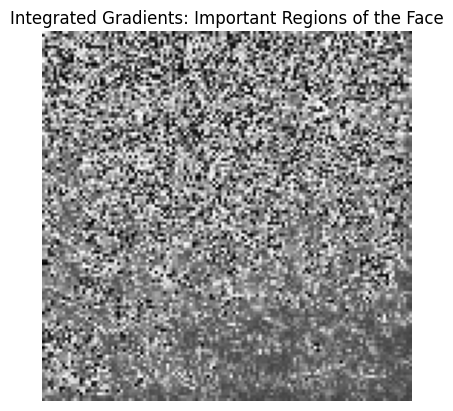

In [8]:
# Imports for explainable AI
from tf_explain.core.grad_cam import GradCAM
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import dlib

# Additional imports for new explainability methods
from tensorflow.keras.applications.resnet50 import ResNet50
from tf_explain.core.integrated_gradients import IntegratedGradients

# Initialize the face detector
face_detector = dlib.get_frontal_face_detector()

# Function to crop face from an image
def crop_face(image, detector):
    # Convert image to 8-bit grayscale if needed
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image

    detected_faces = detector(gray_image, 1)
    if len(detected_faces) > 0:
        d = detected_faces[0]
        left, top, right, bottom = (d.left(), d.top(), d.right(), d.bottom())
        return image[top:bottom, left:right]
    return None  # If no face detected, return None

# Define image size (replace with your actual image size)
image_size = (128, 128)  # Updated to match the model's expected input shape

# Redefine the image input and create a sub-model for the image part
image_input = Input(shape=(*image_size, 3), name="image_input")
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
conv_layer_output = base_model.get_layer('conv5_block3_out').output
sub_model = Model(inputs=base_model.input, outputs=conv_layer_output)

# Define a function for Grad-CAM visualization
def plot_gradcam(sub_model, full_model, image, class_index, img_size):
    face = crop_face(image, face_detector)
    if face is None:
        print("No face detected in the image.")
        return
    try:
        face_resized = cv2.resize(face, img_size)
    except Exception as e:
        print(f"Error resizing face: {e}")
        return

    explainer = GradCAM()
    # Get the predictions from the full model
    full_model_output = full_model.predict({'image_input': face_resized.reshape(1, *img_size, 3), 'tabular_input': np.zeros((1, X_tabular_train.shape[1]))})
    # Explain using the sub-model and full model's predictions
    grid = explainer.explain(validation_data=(face_resized.reshape(1, *img_size, 3), None), model=sub_model, layer_name='conv5_block3_out', class_index=class_index)
    explainer.save(grid, '.', 'gradcam.jpg')
    img = cv2.imread('gradcam.jpg')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Grad-CAM: Important Regions of the Face')
    plt.xlabel('Overlaying the heatmap on the face image shows the regions that influenced the age prediction the most.')
    plt.show()

# Define a function for Integrated Gradients visualization
def plot_integrated_gradients(sub_model, full_model, image, class_index, img_size):
    face = crop_face(image, face_detector)
    if face is None:
        print("No face detected in the image.")
        return
    try:
        face_resized = cv2.resize(face, img_size)
    except Exception as e:
        print(f"Error resizing face: {e}")
        return

    explainer = IntegratedGradients()
    grid = explainer.explain(validation_data=(face_resized.reshape(1, *img_size, 3), None), model=sub_model, class_index=class_index)
    explainer.save(grid, '.', 'integrated_gradients.jpg')
    img = cv2.imread('integrated_gradients.jpg')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Integrated Gradients: Important Regions of the Face')
    plt.xlabel('Overlaying the heatmap on the face image shows the regions that influenced the age prediction the most.')
    plt.show()

# Define the function to extract images from the generator
def extract_images_from_generator(generator, start_index, end_index):
    """
    Extracts images from a generator between the specified indices.

    Args:
        generator: The image generator from which to extract images.
        start_index: The starting index (inclusive).
        end_index: The ending index (exclusive).

    Returns:
        A list of images extracted from the generator.
    """
    images = []
    for i in range(start_index, end_index):
        # Assuming the generator yields images in batches
        batch = next(generator)
        if isinstance(batch, tuple):
            # If the generator yields (images, labels), take only the images
            batch_images = batch[0]
        else:
            batch_images = batch
        images.extend(batch_images)
    return images

# Example of using Grad-CAM and Integrated Gradients
# Replace `train_image_generator` with your actual image generator
example_images = extract_images_from_generator(train_image_generator, 30, 34)  # Images from the 31st to 34th in the training set

# Visualization for Grad-CAM and Integrated Gradients (Heatmaps)
class_index = 0  # Assuming the class index you want to visualize is 0
num_images_to_display = 4  # Number of images to display

for i in range(min(num_images_to_display, len(example_images))):  # Display only 4 images
    plot_gradcam(sub_model, best_model, example_images[i], class_index, image_size)
    plot_integrated_gradients(sub_model, best_model, example_images[i], class_index, image_size)

In [9]:
pip install pandas numpy scikit-learn shap lime matplotlib

Note: you may need to restart the kernel to use updated packages.


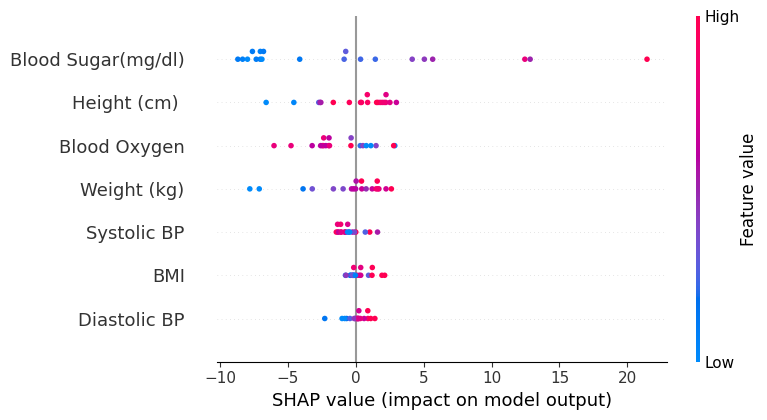

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


              Feature  Importance
4  Blood Sugar(mg/dl)    0.428673
3        Blood Oxygen    0.178472
5         Systolic BP    0.103635
1         Weight (kg)    0.103250
0        Height (cm)     0.086210
6        Diastolic BP    0.051116
2                 BMI    0.048645


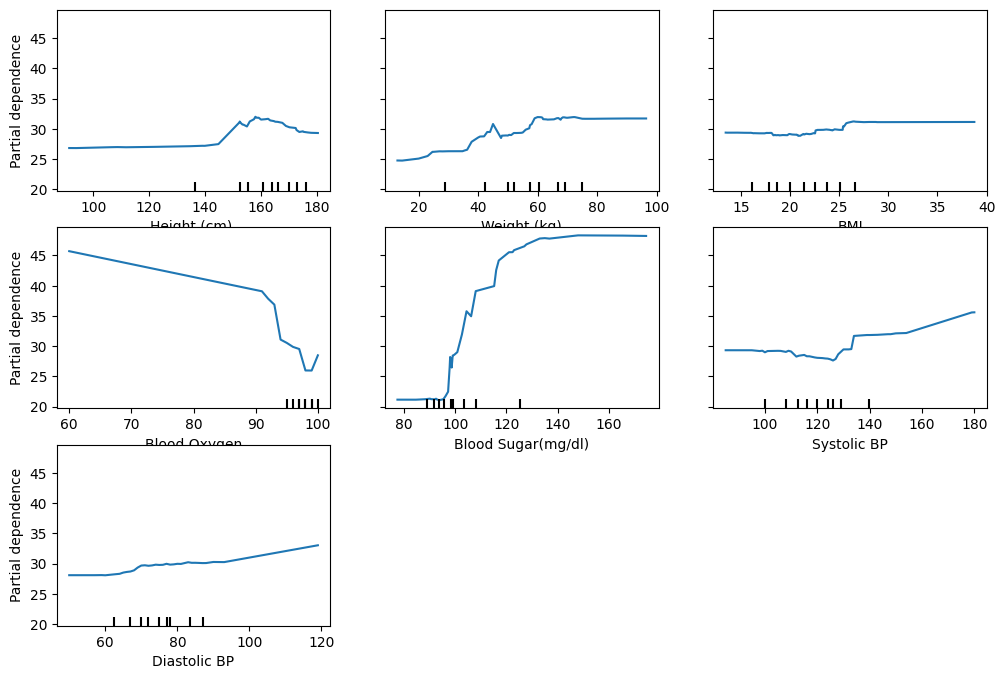

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Load the data
data = pd.read_csv('/kaggle/input/asifazmain/tabulardata1.csv')

# Preprocessing
# Handle invalid blood pressure entries
def split_blood_pressure(bp):
    try:
        systolic, diastolic = bp.split('/')
        return float(systolic), float(diastolic)
    except:
        return np.nan, np.nan  # Return NaN for invalid entries

# Apply the function to split blood pressure
data[['Systolic BP', 'Diastolic BP']] = data['Blood Pressure (s/d)'].apply(split_blood_pressure).apply(pd.Series)

# Drop rows with invalid blood pressure values
data.dropna(subset=['Systolic BP', 'Diastolic BP'], inplace=True)

# Drop unnecessary columns
data.drop(columns=['Blood Pressure (s/d)', 'faceImage'], inplace=True)

# Define features and target
X = data.drop(columns=['Age(years)'])
y = data['Age(years)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# LIME Analysis
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, mode='regression')
instance = X_test.iloc[0].values  # Explain the first instance in the test set
exp = explainer_lime.explain_instance(instance, model.predict, num_features=len(X.columns))
exp.show_in_notebook()

# Feature Importance Ranking
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Partial Dependence Plots (PDPs)
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(model, X_train, features=X.columns, ax=ax)
plt.show()

In [ ]:
# ====================== FINAL WORKING CODE ======================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os
import gc

# ----------------------------- SETTINGS -----------------------------
os.makedirs('/kaggle/working/models', exist_ok=True)

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 8
EPOCHS = 350
N_SPLITS = 5
N_REPEATS = 10   # 50 folds total → ultra-reliable estimate

# ----------------------------- LOAD DATA -----------------------------
df = pd.read_csv('/kaggle/input/asifazmain/tabulardata1.csv')
image_dir = '/kaggle/input/asifazmain/imagedata/imagedata/'

ages = df["Age(years)"].values.astype(float)
image_ids = df["faceImage"].values
X_tab_raw = df.drop(columns=["faceImage", "Age(years)"])

# ----------------------------- PREPROCESSING (FIT ONCE) -----------------------------
cat_cols = ["Blood Pressure (s/d)"]
num_cols = [c for c in X_tab_raw.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

X_tab_processed = preprocessor.fit_transform(X_tab_raw)
if hasattr(X_tab_processed, "toarray"):
    X_tab_processed = X_tab_processed.toarray()

# Critical: RobustScaler for heavily skewed age
label_scaler = RobustScaler()
y_scaled = label_scaler.fit_transform(ages.reshape(-1, 1)).flatten()

# Save for later inference
joblib.dump(preprocessor, '/kaggle/working/models/preprocessor.pkl')
joblib.dump(label_scaler, '/kaggle/working/models/label_scaler.pkl')

# ----------------------------- STRATIFICATION -----------------------------
def get_strata(age):
    return pd.cut(age, bins=[0, 18, 31, 50, 100], labels=[0,1,2,3], include_lowest=True).astype(int)

rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

# ----------------------------- TINY STABLE MODEL -----------------------------
def create_model(tabular_dim):
    # Image branch – extremely small & stable
    img_in = Input(shape=(*IMAGE_SIZE, 3), name='img')
    x = Conv2D(16, 5, padding='same', activation='relu')(img_in)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Conv2D(32, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.35)(x)

    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    img_features = Dense(32, activation='relu')(x)

    # Tabular branch
    tab_in = Input(shape=(tabular_dim,), name='tab')
    t = Dense(64, activation='relu')(tab_in)
    t = BatchNormalization()(t)
    t = Dropout(0.5)(t)
    t = Dense(32, activation='relu')(t)

    # Fusion
    merged = Concatenate()([img_features, t])
    merged = Dropout(0.5)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(32, activation='relu')(merged)
    output = Dense(1, activation='linear')(merged)

    model = Model(inputs=[img_in, tab_in], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss='mse',
        metrics=['mae']
    )
    return model

# ----------------------------- CV LOOP -----------------------------
mae_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(rkf.split(X_tab_processed, get_strata(ages)), 1):
    print(f"\n{'='*15} Fold {fold} / {N_SPLITS*N_REPEATS} {'='*15}")

    # Data split
    X_train_tab = X_tab_processed[train_idx]
    X_val_tab   = X_tab_processed[val_idx]
    y_train_sc  = y_scaled[train_idx]
    y_val_sc    = y_scaled[val_idx]
    y_val_true  = ages[val_idx]
    img_train   = image_ids[train_idx]
    img_val     = image_ids[val_idx]

    # Minimal augmentation (critical for tiny data)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=8,
        width_shift_range=0.08,
        height_shift_range=0.08,
        zoom_range=0.08,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_dataframe(
        pd.DataFrame({'filename': [f"{i}.jpg" for i in img_train]}),
        directory=image_dir,
        x_col='filename',
        y_col=None,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=True,
        seed=42
    )

    val_gen = val_datagen.flow_from_dataframe(
        pd.DataFrame({'filename': [f"{i}.jpg" for i in img_val]}),
        directory=image_dir,
        x_col='filename',
        y_col=None,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )

    # Perfectly aligned generator
    def aligned_generator(image_gen, tab_data, labels_sc):
        while True:
            imgs = next(image_gen)
            batch_size = len(imgs)
            start_idx = (image_gen.batch_index * batch_size) % len(tab_data)
            idx = (np.arange(start_idx, start_idx + batch_size)) % len(tab_data)
            yield (imgs, tab_data[idx]), labels_sc[idx]

    # Train
    model = create_model(X_tab_processed.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_mae', patience=45, restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=15, min_lr=1e-7)
    ]

    model.fit(
        aligned_generator(train_gen, X_train_tab, y_train_sc),
        steps_per_epoch=len(img_train) // BATCH_SIZE + 1,
        validation_data=aligned_generator(val_gen, X_val_tab, y_val_sc),
        validation_steps=len(img_val) // BATCH_SIZE + 1,
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks
    )

    # Predict
    preds_scaled = model.predict(
        aligned_generator(val_gen, X_val_tab, y_val_sc),
        steps=len(img_val) // BATCH_SIZE + 1
    )[:len(val_idx)]

    preds = label_scaler.inverse_transform(preds_scaled).flatten()

    mae = mean_absolute_error(y_val_true, preds)
    r2 = r2_score(y_val_true, preds)

    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold} → MAE: {mae:.3f} years | R²: {r2:.3f}")

    # Clean up
    del model, train_gen, val_gen
    gc.collect()
    tf.keras.backend.clear_session()

# ----------------------------- FINAL RESULT -----------------------------
print("\n" + "="*70)
print(f"10×5 Repeated Stratified Cross-Validation (50 folds)")
print(f"Final MAE : {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f} years")
print(f"Final R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print("="*70)


=============== Fold 1 / 50 ===============
Found 80 validated image filenames.
Found 21 validated image filenames.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step
Fold 1 → MAE: 12.741 years | R²: -0.060

=============== Fold 2 / 50 ===============
Found 81 validated image filenames.
Found 20 validated image filenames.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
Fold 2 → MAE: 14.070 years | R²: -0.246

=============== Fold 3 / 50 ===============
Found 81 validated image filenames.
Found 20 validated image filenames.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
Fold 3 → MAE: 9.831 years | R²: -0.035

=============== Fold 4 / 50 ===============
Found 81 validated image filenames.
Found 20 validated image filenames.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step
Fold 4 → MAE: 13.489 years | R²: -0.182

=============== Fold 5 / 50 ===============
Found 81 validated image filenames.
Found 20 validated image filenames.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
Fold 5 → MAE: 14.098 years | R²: -0.104

=============== Fold

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import joblib
import os
import gc

# =============================
# CONFIG
# =============================
output_dir = '/kaggle/working/models'
os.makedirs(output_dir, exist_ok=True)
image_data_path = '/kaggle/input/asifazmain/imagedata/imagedata/'
image_size = (128, 128)
batch_size = 8
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# =============================
# LOAD & PREPROCESS
# =============================
df = pd.read_csv('/kaggle/input/asifazmain/tabulardata1.csv')
image_ids = df["faceImage"].values
ages = df["Age(years)"].values.astype(float)

# Scale age
scaler = StandardScaler()
y_scaled = scaler.fit_transform(ages.reshape(-1, 1)).ravel()
joblib.dump(scaler, f'{output_dir}/label_scaler.pkl')

# Tabular features
X_raw = df.drop(columns=["faceImage", "Age(years)"])
cat_cols = ["Blood Pressure (s/d)"]
num_cols = [c for c in X_raw.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_cols)
])
X_processed = preprocessor.fit_transform(X_raw)
joblib.dump(preprocessor, f'{output_dir}/preprocessor.pkl')

# =============================
# PRE-LOAD IMAGES (FAST!)
# =============================
print("Loading all images into RAM...")
images = np.array([
    img_to_array(load_img(f"{image_data_path}{id}.jpg", target_size=image_size)) / 255.0
    for id in image_ids
])
print(f"Done! Shape: {images.shape}")

# =============================
# TRAIN-TEST SPLIT
# =============================
train_idx, test_idx = train_test_split(
    range(len(df)), test_size=0.2, random_state=seed, shuffle=True
)

X_img_train, X_img_test = images[train_idx], images[test_idx]
X_tab_train, X_tab_test = X_processed[train_idx], X_processed[test_idx]
y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

# =============================
# FAST tf.data
# =============================
def make_dataset(img, tab, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((
        {"image_input": img, "tabular_input": tab.astype(np.float32)},
        y.astype(np.float32)
    ))
    if shuffle:
        ds = ds.shuffle(1000, seed=seed)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_img_train, X_tab_train, y_train, shuffle=True)
test_ds  = make_dataset(X_img_test,  X_tab_test,  y_test,  shuffle=False)

# =============================
# FINAL WORKING MODEL 
# =============================
def build_model(hp, loss_fn):
    # Image branch
    img_in = Input(shape=(128,128,3), name="image_input")
    x = img_in
    for i in range(4):
        f = hp.Int(f'filters_{i}', 32, 256, step=32)
        x = Conv2D(f, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        if i < 3:
            x = MaxPooling2D(2)(x)
    x = GlobalAveragePooling2D()(x)
    img_feat = Dense(64, activation='relu', name='img_feat')(x)

    # Tabular branch
    tab_in = Input(shape=(X_processed.shape[1],), name="tabular_input")
    y = Dense(hp.Int('tab_units', 64, 256, step=64), activation='relu')(tab_in)
    y = Dropout(hp.Float('tab_drop', 0.2, 0.6))(y)
    tab_feat = Dense(64, activation='relu', name='tab_feat')(y)

    # CORRECT FUSION (both are 64-dim → everything works)
    concat = Concatenate()([img_feat, tab_feat])           # → (None, 128)
    fused  = Multiply()([img_feat, tab_feat])              # → (None, 64)
    fused  = Dense(128, activation='relu')(fused)          # → (None, 128)

    combined = Add()([concat, fused])                      # → (None, 128)

    z = Dense(hp.Int('final_units', 64, 256, step=64), activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='linear')(z)

    model = Model([img_in, tab_in], output)
    model.compile(
        optimizer=AdamW(learning_rate=hp.Float('lr', 1e-5, 1e-3, sampling='log')),
        loss=loss_fn,
        metrics=['mae']
    )
    return model

# =============================
# ABLATION: MSE vs HUBER 
# =============================
results = {}

for loss_name, loss_fn in [("MSE", "mse"), ("Huber", tf.keras.losses.Huber(delta=1.0))]:
    print(f"\n{'='*70}")
    print(f" TRAINING WITH {loss_name.upper()} LOSS ".center(70))
    print(f"{'='*70}")

    tuner = RandomSearch(
        lambda hp: build_model(hp, loss_fn),
        objective='val_mae',
        max_trials=10,
        executions_per_trial=1,
        directory=f'tuner_{loss_name.lower()}',
        project_name='age_final',
        overwrite=True
    )

    tuner.search(
        train_ds,
        validation_data=test_ds,
        epochs=200,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=40, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=15)
        ],
        verbose=1
    )

    best_model = tuner.get_best_models(1)[0]

    # Evaluate
    pred_scaled = best_model.predict(test_ds, verbose=0).flatten()
    pred_orig = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
    true_orig = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    mae = np.mean(np.abs(pred_orig - true_orig))
    r2 = r2_score(true_orig, pred_orig)
    acc_05 = np.mean(np.abs(pred_orig - true_orig) <= 0.5) * 100

    results[loss_name] = mae
    print(f"\n{loss_name} RESULTS:")
    print(f"   MAE : {mae:.3f} years")
    print(f"   R²  : {r2:.4f}")
    print(f"   ±0.5y Accuracy: {acc_05:.1f}%\n")

    best_model.save(f"{output_dir}/final_{loss_name.lower()}.keras")

    del tuner, best_model
    tf.keras.backend.clear_session()
    gc.collect()

# =============================
# FINAL RESULT
# =============================
print("\n" + "="*70)
print("ABLATION COMPLETE - FINAL COMPARISON")
print("="*70)
for name, mae in results.items():
    print(f"{name:5} → MAE = {mae:6.3f} years")

winner = "Huber" if results["Huber"] < results["MSE"] else "MSE"
print(f"\nWINNER → {winner} (lower MAE is better)")

Trial 10 Complete [00h 00m 22s]
val_mae: 0.5024006962776184

Best val_mae So Far: 0.41296958923339844
Total elapsed time: 00h 04m 33s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Huber RESULTS:
   MAE : 7.115 years
   R²  : 0.6083
   ±0.5y Accuracy: 0.0%


ABLATION COMPLETE - FINAL COMPARISON
MSE   → MAE =  6.368 years
Huber → MAE =  7.115 years

WINNER → MSE (lower MAE is better)
